In [33]:
import sys


sys.path.insert(0, "../../..")

from dinov2.data.loaders import make_dataset
import matplotlib.pyplot as plt
from dinov2.data import DataAugmentationDINO

import numpy as np
import torch
import torch

from dinov2.data.collate import collate_data_and_cast
from dinov2.data import make_data_loader

from functools import partial

from dinov2.models.vision_transformer import DinoVisionTransformer

from dinov2.layers import (
    MemEffAttention,
    PatchEmbed,
    SwiGLUFFNFused,
)
from dinov2.layers import (
    NestedTensorBlock as Block,
)

root = "/fast/AG_Kainmueller/data/pan_m_lmdb_crops/vectra_pancreas"
# vectra_colon: 7 ch, vectra_pancreas: 7 ch, codex_colon: 50 ch, mibi_breast: 39 ch, mibi_decidua: 38 ch
ds_path = f"PanMDataset:split=ALL:root={root}:extra=*"

In [35]:
import glob
import os

file_list = glob.glob(root, '*') # os.path.join(root, '*'))
print(file_list)

TypeError: glob() takes 1 positional argument but 2 were given

In [23]:
data_transform_cpu = DataAugmentationDINO(
    [0.32, 0.8],
    [0.05, 0.32],
    local_crops_number=8,
    global_crops_size=224,
    local_crops_size=96,
    use_kornia=True,
    use_native_res=False,
    do_seg_crops=None,
    patch_size=14,
    do_multi_channel=True
)

dataset = make_dataset(
    dataset_str=ds_path,
    transform=data_transform_cpu,
    target_transform=lambda x: (),
    with_targets=False,
    cache_dataset=False,
)

Dataset kwargs {'split': <_Split.ALL: 'all'>, 'root': '/fast/AG_Kainmueller/data/pan_m_lmdb_crops/mibi_decidua/', 'extra': '*'}
extra_path /fast/AG_Kainmueller/data/pan_m_lmdb_crops/mibi_decidua/*
Datasets imgs file list:  ['/fast/AG_Kainmueller/data/pan_m_lmdb_crops/mibi_decidua/0-TRAIN_images']
Datasets labels file list:  ['/fast/AG_Kainmueller/data/pan_m_lmdb_crops/mibi_decidua/0-TRAIN_labels']
Datasets metadata file list:  ['/fast/AG_Kainmueller/data/pan_m_lmdb_crops/mibi_decidua/0-TRAIN_metadata']
/fast/AG_Kainmueller/data/pan_m_lmdb_crops/mibi_decidua/0-TRAIN_images lmdb_env_imgs.stat() {'psize': 4096, 'depth': 3, 'branch_pages': 7, 'leaf_pages': 568, 'overflow_pages': 76045, 'entries': 34504}


In [24]:
dataset

Dataset PanMDataset
    Number of datapoints: 908
    Root location: /fast/AG_Kainmueller/data/pan_m_lmdb_crops/mibi_decidua/
    StandardTransform
Transform: <dinov2.data.augmentations.DataAugmentationDINO object at 0x2b441d02bf40>
Target transform: <function <lambda> at 0x2b441f0f76d0>

img.shape 0 torch.Size([38, 224, 224])  p shape  torch.Size([224, 224, 38])
img.shape 1 torch.Size([38, 224, 224])  p shape  torch.Size([224, 224, 38])
img.shape 2 torch.Size([38, 96, 96])  p shape  torch.Size([96, 96, 38])
img.shape 3 torch.Size([38, 96, 96])  p shape  torch.Size([96, 96, 38])
img.shape 4 torch.Size([38, 96, 96])  p shape  torch.Size([96, 96, 38])
img.shape 5 torch.Size([38, 96, 96])  p shape  torch.Size([96, 96, 38])
img.shape 6 torch.Size([38, 96, 96])  p shape  torch.Size([96, 96, 38])
img.shape 7 torch.Size([38, 96, 96])  p shape  torch.Size([96, 96, 38])
img.shape 0 torch.Size([38, 224, 224])  p shape  torch.Size([224, 224, 38])
img.shape 1 torch.Size([38, 224, 224])  p shape  torch.Size([224, 224, 38])
img.shape 2 torch.Size([38, 96, 96])  p shape  torch.Size([96, 96, 38])
img.shape 3 torch.Size([38, 96, 96])  p shape  torch.Size([96, 96, 38])
img.shape 4 torch.Size([38, 96, 96])  p shape  torch.Size([96, 96, 38])
img.shape 5 torch.Size([38, 96, 96])  p shape  t

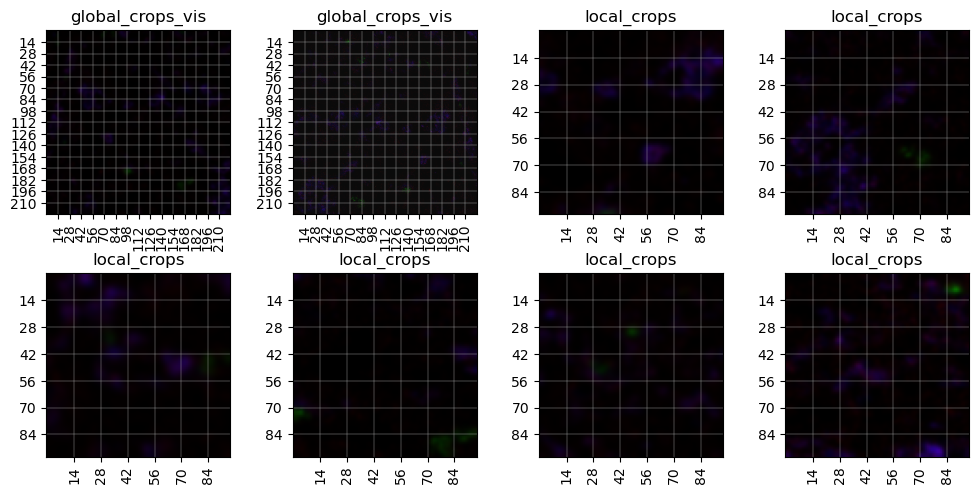

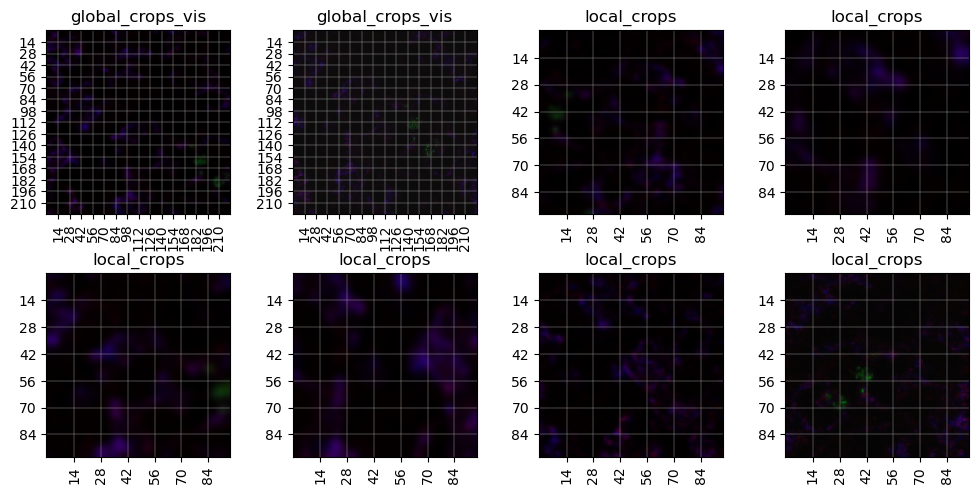

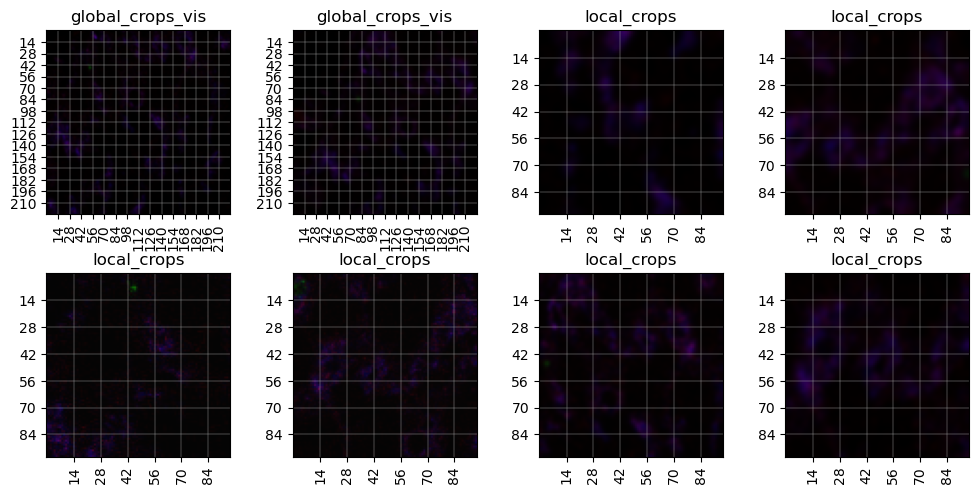

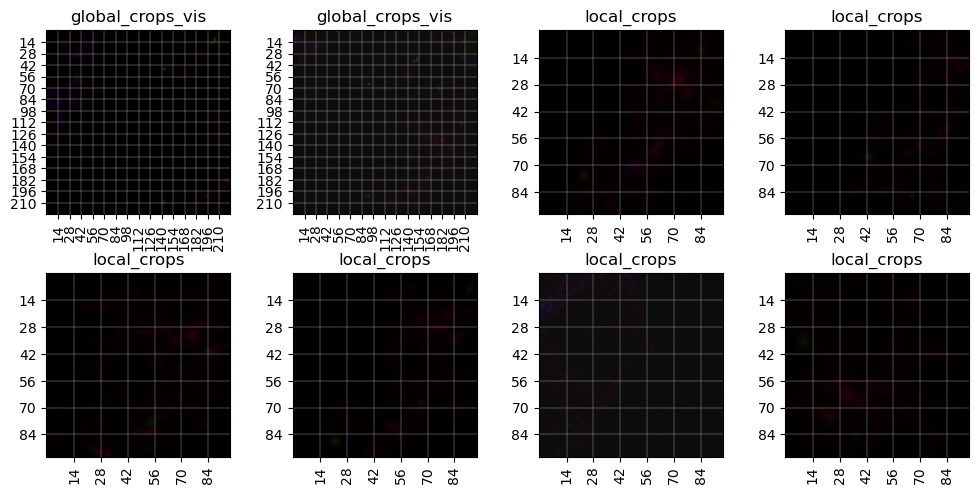

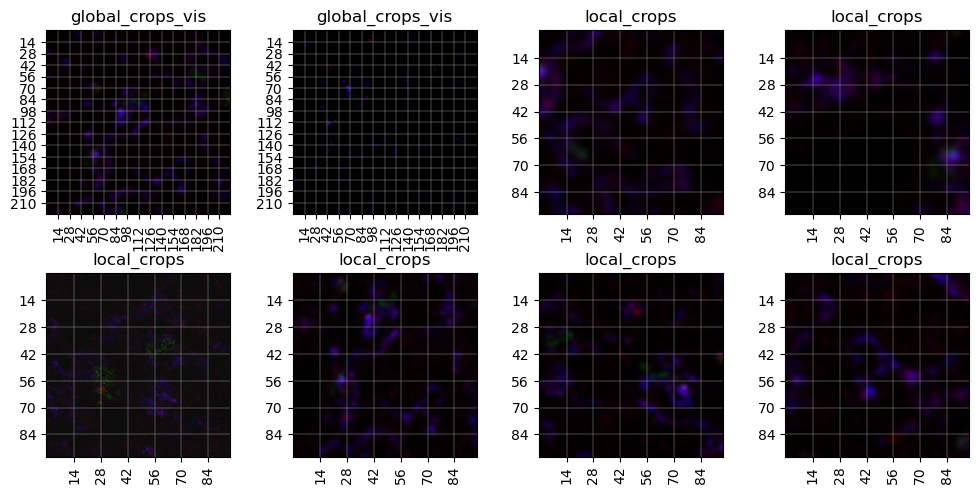

In [25]:
for i in range(5):
    # dict_keys(['global_crops', 'local_crops', 'offsets'])
    imgs = dataset[i][0]

    do_plot = True
    """
    for k in imgs.keys():
        for img in imgs[k]:
            if torch.std(img) < 1e-3:
                print(torch.std(img))
                do_plot = True
                break

        # f2, a2 = plt.subplots(1, 1)
        # plt.hist(img.flatten(), bins=40)
    """
    if do_plot:
        nb_x_plots, nb_y_plots = 2, 4
        f, a = plt.subplots(nb_x_plots, nb_y_plots)
        f.set_size_inches(10, 5)
        f.tight_layout()
        count = 0
        key_list = ["global_crops_vis"]
        if "local_crops_vis" in imgs.keys():
            key_list += ["local_crops_vis"]
        else:
            key_list += ["local_crops"]
        for k in key_list:
            for img in imgs[k]:
                if len(img.shape) > 3:
                    img = img[0]
                if len(img.shape) == 2:
                    img = img[None, :, :].repeat((3, 1, 1))
                print("img.shape", count, img.shape, ' p shape ', img.permute(1, 2, 0).shape)

                norm_img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
                a[count // 4, count % 4].imshow(norm_img.permute(1, 2, 0)[:,:,:3])
                a[count // 4, count % 4].set_title(k)
                xticks = np.arange(14, norm_img.shape[2], 14)
                yticks = np.arange(14, norm_img.shape[1], 14)
                a[count // 4, count % 4].set_xticks(xticks)
                a[count // 4, count % 4].set_yticks(yticks)
                a[count // 4, count % 4].xaxis.grid(True, linewidth=0.3)
                a[count // 4, count % 4].yaxis.grid(True, linewidth=0.3)
                a[count // 4, count % 4].set_xticklabels(xticks, rotation=90)
                count += 1
                if count // 4 >= nb_x_plots or count % 4 >= nb_y_plots:
                    break
            else:
                continue  # only executed if the inner loop did NOT break
            break
        if "pooled_seg" in imgs.keys():
            img = imgs["pooled_seg"]
            print("pooled_vals", np.unique(img))
            norm_img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
            a[-1, -1].imshow(norm_img)
            a[-1, -1].set_title("crops overview")
            colors = ["r", "g", "b", "y", "k", "m", "c", "w"]
            if "bboxes" in imgs.keys():
                for i, bbox in enumerate(imgs["bboxes"]):
                    a[-1, -1].plot(
                        [bbox[0], bbox[2]],
                        [bbox[1], bbox[1]],
                        colors[i % len(colors)],
                        lw=1,
                        label=i,
                    )
                    a[-1, -1].plot(
                        [bbox[0], bbox[2]],
                        [bbox[3], bbox[3]],
                        colors[i % len(colors)],
                        lw=1,
                    )
                    a[-1, -1].plot(
                        [bbox[0], bbox[0]],
                        [bbox[1], bbox[3]],
                        colors[i % len(colors)],
                        lw=1,
                    )
                    a[-1, -1].plot(
                        [bbox[2], bbox[2]],
                        [bbox[1], bbox[3]],
                        colors[i % len(colors)],
                        lw=1,
                    )

            xticks = np.arange(14, norm_img.shape[1], 14)
            yticks = np.arange(14, norm_img.shape[0], 14)
            a[-1, -1].set_xticks(xticks)
            a[-1, -1].set_yticks(yticks)
            a[-1, -1].set_xticklabels(xticks, rotation=90)
            a[-1, -1].xaxis.grid(True)
            a[-1, -1].yaxis.grid(True)
            a[-1, -1].legend(bbox_to_anchor=(1.1, 1.05))
            plt.tight_layout()
        """
        if "local_crops" in imgs.keys():
            f, a = plt.subplots(6, 1)
            f.set_size_inches(20, 10)
            f.tight_layout()
            lc = imgs["local_crops"]
            print(lc.shape)
            norm_lc = (lc - torch.min(lc)) / (torch.max(lc) - torch.min(lc))
            for idx in range(0, 2940, 490):
                a[idx // 490].imshow(
                    norm_lc[:, idx : idx + 490, :].permute((2,1, 0)),
                    label=i,
                )
                a[idx // 490].set_xticks(np.arange(14, 490, 14))
        """

In [18]:
print(img.shape)

print(img[0,:4,:4])

img = (img - img.min())/(img.max()-img.min())
print(img[0,:4,:4])


torch.Size([7, 96, 96])
tensor([[-6.3707, -6.3778, -6.3933, -6.3988],
        [-6.3897, -6.3953, -6.4071, -6.4095],
        [-6.4337, -6.4362, -6.4409, -6.4374],
        [-6.4733, -6.4727, -6.4698, -6.4611]])


In [22]:
img = np.array(img*255).astype(np.uint8)

In [28]:
print(img[:3,:,:].shape, img[:3,:,:].dtype)


(3, 96, 96) uint8


In [29]:
import imageio.v3 as iio


jpg_encoded = iio.imwrite("<bytes>", img[0,:,:], extension=".jpeg")


In [31]:
torch.from_numpy(iio.imread(jpg_encoded, index=None)).shape


torch.Size([96, 96])

In [ ]:
import sys

sys.path.insert(0, "..")
from dinov2.data.masking import MaskingGenerator
import matplotlib.pyplot as plt
import numpy as np

img_size_x = 140
img_size_y = 154
patch_size = 14
mask_generator = MaskingGenerator(
    input_size=(img_size_y // patch_size, img_size_x // patch_size),
    max_num_patches=0.5 * img_size_y // patch_size * img_size_x // patch_size,
)

f, a = plt.subplots(3, 4)
plt.suptitle("Examples of generated masks")
for i in range(12):
    m1 = mask_generator(num_masking_patches=30)
    a[i // 4, i % 4].imshow(m1)
plt.tight_layout()
plt.show()

In [ ]:

def list_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

data_loader = make_data_loader(
    dataset=dataset,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    seed=0,
    sampler_type=None,
    sampler_advance=0,
    drop_last=True,
    collate_fn=list_collate,
)

img_size = 224
patch_size = 14
mask_generator = MaskingGenerator(
    input_size=(img_size // patch_size, img_size // patch_size),
    max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
)

In [ ]:
model = DinoVisionTransformer(
    patch_size=14,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    block_fn=partial(Block, attn_class=MemEffAttention),
    num_register_tokens=0,
    img_size=224,
    in_chans=3,
    drop_path_rate=0.0,
    drop_path_uniform=True,
    init_values=1.0e-05,  # for layerscale: None or 0 => no layerscale
    embed_layer=PatchEmbed,
    ffn_layer="mlp",
    block_chunks=1,
    interpolate_antialias=False,
    interpolate_offset=0.1,
)

In [ ]:
out = None
torch.cuda.empty_cache()
for i, el in enumerate(data_loader):
    if i > 2:
        break
    el = el[0]
    # list of len batch size containing dicts
    collated_dict = collate_data_and_cast(
        el,
        mask_ratio_tuple=(0.1, 0.5),
        mask_probability=0.5,
        dtype=torch.half,
        n_tokens=200,
        mask_generator=mask_generator,
        free_shapes=True,
    )

    model.cuda()
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            out = model(
                [
                    collated_dict["collated_global_crops"].cuda(),
                    collated_dict["collated_local_crops"].cuda(),
                ],
                masks=[collated_dict["collated_masks"].cuda(), None],
                is_training=True,
                # attn_masks=[collated_dict["attn_mask_gc"].cuda(),collated_dict["attn_mask_lc"].cuda()]
            )
            print(out[0]["x_norm_clstoken"].shape)


In [ ]:
for i in range(len(out)):
    for k in out[i].keys():
        if out[i][k] is not None:
            print(k, out[i][k].shape)

In [ ]:
import numpy as np

aa = np.zeros((100,100))

print(aa.shape)

In [ ]:
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries
import torchvision
from torchvision.transforms.functional import InterpolationMode

img = dataset[1][0]["global_crops"][0]

if not torch.is_tensor(img):
    img = torch.tensor(img)

# img = imgs["global_crops"][0]
img = (img - img.min()) / (img.max() - img.min())
print(img.dtype, img.max(), img.min())
img = (img * 255).to(torch.uint8)
img_gray = img[0, :, :]

if img.size(0) == 3:
    img = img.permute((1, 2, 0))

orig_img_dims = img.shape[:2]
print(f"image shape {img.shape}")

grid_x, grid_y = torch.meshgrid(
    torch.arange(img_gray.size(0)), torch.arange(img_gray.size(1)), indexing="ij"
)
grid_x = (grid_x - torch.min(grid_x)) / (torch.max(grid_x) - torch.min(grid_x)) * 2
grid_y = (grid_y - torch.min(grid_y)) / (torch.max(grid_y) - torch.min(grid_y)) * 2

preprocessed_data = torch.stack([img_gray, grid_x, grid_y], dim=2).flatten(0, -2)
print(preprocessed_data.size())

segments_quick = quickshift(img, kernel_size=20, max_dist=15, ratio=0.5)
segments_slic = slic(img, n_segments=10, compactness=10, sigma=1.0, start_label=1)
start_t = datetime.now()
segments_fz = felzenszwalb(img, scale=300, sigma=0.5, min_size=700)
delta_fz = datetime.now() - start_t
print('FZ: ', delta_fz)

# saved args
# segments_quick = quickshift(img, kernel_size=7, max_dist=7, ratio=0.5)
# segments_slic = slic(img, n_segments=10, compactness=10, sigma=1.0, start_label=1)
# segments_fz = felzenszwalb(img, scale=150, sigma=0.5, min_size=150)

print(f"quick #{segments_quick.max()}")

kmeans_op = KMeans(n_clusters=10)
res = kmeans_op.fit_predict(preprocessed_data)
img_labels = res.reshape(img_gray.size())

n_plots = 4
f, a = plt.subplots(1, n_plots)
f.set_size_inches(18, 6)
a[0].imshow(img)
a[1].imshow(mark_boundaries(np.array(img), segments_quick))
a[1].set_title("quickshift")
a[2].imshow(mark_boundaries(np.array(img), segments_slic))
a[2].set_title("SLIC")
a[3].imshow(mark_boundaries(np.array(img), segments_fz))
a[3].set_title("felzenszwalb")

# a[4].imshow(img_labels)
# a[4].imshow(mark_boundaries(np.array(img), img_labels))
# for i in range(4, n_plots):
#    a[i].imshow(mark_boundaries(np.array(img), segments_quick == i))

plt.savefig("segmentations.jpg", dpi=200)
plt.show()

In [ ]:
patch_size = 14
local_crop_size = 224
maxpool_op = torch.nn.MaxPool2d(
    kernel_size=patch_size,
    stride=patch_size,
    padding=0,
    dilation=1,
    return_indices=False,
)

# Not used
unpool_op = torch.nn.MaxUnpool2d(kernel_size=patch_size, stride=patch_size, padding=0)

resize_op = torchvision.transforms.Resize(
    orig_img_dims, interpolation=InterpolationMode.NEAREST_EXACT, antialias=False
)

In [ ]:
def seg_to_patched_seg(segments):
    segments = segments / segments.max()
    conv_input = torch.tensor(segments[None, :, :])
    pooled_seg = maxpool_op(conv_input)

    resized_masks = resize_op(pooled_seg)[0, :, :]
    print(np.unique(resized_masks))
    resized_masks_int = (resized_masks * len(np.unique(resized_masks))).to(torch.int32)

    # map tensor to continuous int values
    unique_vals = torch.unique(resized_masks_int)
    lt = torch.full((int(resized_masks_int.max()) + 1,), -1)
    lt[unique_vals] = torch.arange(len(unique_vals))
    resized_masks_int = lt[resized_masks_int]

    return pooled_seg, resized_masks_int

In [ ]:
from torchvision.ops import masks_to_boxes

for seg, name in zip(
    [segments_slic, segments_quick, segments_fz],
    ["SLIC", "Quickshift", "Felzenschwalb"],
):
    print(name, img.shape)
    pooled_seg, resized_masks_int = seg_to_patched_seg(seg)

    max_mask_idx = max(np.unique(resized_masks_int))
    print(f"# Masks {(np.unique(resized_masks_int))}")

    n_plots = 5
    f, a = plt.subplots(1, n_plots)
    f.set_size_inches(15, 7)
    a[0].set_title("original")
    a[1].set_title("segmentation")
    a[2].set_title("crops ->")

    a[0].imshow(img)
    a[0].set_xticks(np.arange(0, img.shape[0], 14), minor=True)
    a[0].set_yticks(np.arange(0, img.shape[1], 14), minor=True)
    a[0].grid(which="minor", color="w", linestyle="-", linewidth=0.3)

    bigger_img = pooled_seg.repeat_interleave(14, dim=1).repeat_interleave(14, dim=2)
    # Alternative
    # a[1].imshow(resize_op(pooled_seg)[0, :, :])
    a[1].imshow(bigger_img[0, :, :])
    a[1].set_xticks(np.arange(0, img.shape[0], 14), minor=True)
    a[1].set_yticks(np.arange(0, img.shape[1], 14), minor=True)
    a[1].grid(which="minor", color="w", linestyle="-", linewidth=0.3)

    img_gray = img[:, :, :1]
    for i in range(2, n_plots):
        mask_idx = i - 1
        print(mask_idx, max_mask_idx)
        if mask_idx > max_mask_idx:
            break
        fragment = torch.zeros(img_gray.shape, dtype=torch.uint8)
        mask_pos = resized_masks_int == mask_idx
        fragment[mask_pos] = img_gray[mask_pos]
        bbox = masks_to_boxes(mask_pos[None, :, :])[0]
        print("bbox", bbox)
        fragment[mask_pos] = fragment[mask_pos]
        a[i].imshow(fragment.repeat([1, 1, 3]))
        a[i].plot([bbox[0], bbox[2]], [bbox[1], bbox[1]], "r-")
        a[i].plot([bbox[0], bbox[2]], [bbox[3], bbox[3]], "r-")
        a[i].plot([bbox[0], bbox[0]], [bbox[1], bbox[3]], "r-")
        a[i].plot([bbox[2], bbox[2]], [bbox[1], bbox[3]], "r-")

    f.tight_layout()
    plt.savefig(f"seg_examples_{name}.jpg", dpi=200, bbox_inches="tight")
    plt.show()